In [1]:
import numpy as np
import scipy.integrate as spint
import scipy.optimize as spy
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import pint
import fluids
import pandas as pd
import GeneralFlow as GF

# General Compressible Flow Setup

In [2]:
# Unit Conversions and Formats Graphs
u = pint.UnitRegistry(autoconvert_offset_to_baseunit=True)
u.setup_matplotlib()
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
GF.GeneralFlow.findInfCoeffMach(1.4, 2.)

{'dMdA': 1.2,
 'dMdH0': -2.1999999999999997,
 'dMdf': -3.3599999999999994,
 'dMdmdot': -7.919999999999999,
 'dMdMW': 2.1999999999999997,
 'dMdgamma': -1.0}

In [4]:
# Old outputs for comparison
# Givens
T1 = 300
P1 = 101325
epsilon = 1e-05
D = (0.5 * u.inches).to('meters').magnitude
rho1 = CP.PropsSI('D', 'T', T1, 'P', P1, 'helium')
visc = CP.PropsSI('V', 'T', T1, 'P', P1, 'helium')
vel = 40
Re = rho1 * vel * D / visc

gamma = CP.PropsSI('isentropic_expansion_coefficient', 'T', T1, 'P', P1, 'helium')
Ru = CP.PropsSI('gas_constant', 'T', T1, 'P', P1, 'helium') * 1000
Cp = CP.PropsSI('CP0MASS', 'T', T1, 'P', P1, 'helium')
MW = CP.PropsSI('M', 'T', T1, 'P', P1, 'helium') * 1000
R = Ru / MW

a1 = np.sqrt(gamma * R * T1)
M1 = vel / a1


rho = P1 / R / T1

# print(gamma)
# print(Ru)
# print(MW)
# print(a1)
# print(M1)
# print(Cp)

# Friction Factor Calculations
fricFactorNormFunc = lambda f : -2.0 * np.log10(epsilon / (3.7 * D) + 2.51 / (Re * np.sqrt(f))) - 1 / np.sqrt(f)
fricFactorFannoFunc = lambda f : -4.0 * np.log10(epsilon / (3.7 * D) + 1.255 / (Re * np.sqrt(f))) - 1 / np.sqrt(f)

fricFactorNorm = spy.fsolve(fricFactorNormFunc, 0.01)
fricFactorFanno = spy.fsolve(fricFactorFannoFunc, 0.01)

# print(fricFactorNorm)
# print(fricFactorFanno)
# print(fricFactorFanno * 4)


f = (0.790 * np.log(Re) - 1.64)**(-2)
# print(f)

Pr = CP.PropsSI('Prandtl', 'T', T1, 'P', P1, 'helium')

Nu1 = 0.023 * Re ** 0.8 * Pr ** 0.3
Nu2 = 0.125 * f * Re * Pr**(1/3)
# print(Nu1)
# print(Nu2)


# General Analytical Solving
M2 = np.linspace(M1, 1, 100000)

strangeNum = 1 + (gamma - 1) / 2 * M2**2
strangeDen = 1 + (gamma - 1) / 2 * M1**2

L = (D / (4 * fricFactorFanno)) * ((1 / gamma) * (1 / M1**2 - 1 / M2**2) + (gamma + 1) / (2 * gamma) * np.log((M1**2 / M2**2) * (strangeNum / strangeDen)))
Tanalytical = T1 * ((2 + (gamma - 1) * np.power(M1, 2)) / (2 + (gamma - 1) * np.power(M2, 2)))
Panalytical = P1 * (M1 / M2) * np.sqrt((2 + (gamma - 1) * np.power(M1, 2)) / (2 + (gamma - 1) * np.power(M2, 2)))
Vanalytical = vel * M2 / M1 * np.sqrt((2 + (gamma - 1) * np.power(M1, 2)) / (2 + (gamma - 1) * np.power(M2, 2)))
RHOanalytical = rho * (M2 / M1 * np.sqrt((2 + (gamma - 1) * np.power(M1, 2)) / (2 + (gamma - 1) * np.power(M2, 2))))**-1



# ODE Setup
# Setup up For ODE SOlver
xStart = 0.
xEnd = 1.20990013e+02
xLen = 100000
xspan = np.linspace(xStart, xEnd, xLen)

# Geometry Array
D_arr1 = np.linspace(0.1, D, int(xLen/5))
D_arr2 = D * np.ones(int(3 * xLen / 5))
D_arr3 = np.linspace(D, 0.05, int(xLen / 5))
D_arr = np.hstack([D_arr1, D_arr2, D_arr3])
# D_arr = D * np.ones(xLen)

# Setting Up initial conditions
P01 = P1 * (1 + (gamma - 1) / 2 * np.power(M1, 2)) ** (gamma / (gamma - 1))
T01 = T1 * (1 + (gamma - 1) / 2 * np.power(M1, 2))
IC = np.array([M1, vel, P01, P1, T01, T1, rho])

# ODE Solver Call
# test = GF.GeneralFlow(x_arr=xspan, D_arr=D_arr, Cp=Cp, gamma=gamma, q=0.0)
# test.setIC(M1, vel, P01, P1, T01, T1, rho, visc, epsilon)
# results = test.run()
# length = results['x']
# Mach = results['Mach']
# test.xdotSolve(0, IC)
# IC

In [5]:
# ODE Solver Call
# test = GF.GeneralFlow(x_arr=xspan, D_arr=D_arr, Cp=Cp, gamma=gamma, q=0.0)
# test.setICBeta(M1, vel, P1, T1, rho1, visc, epsilon)
# results = test.runBeta()
# lengthBeta = results['x']
# MachBeta = np.array(results['Mach'])
# pressBeta = np.array(results['P'])
# tempBeta = np.array(results['T'])
# print(results['reason'])

In [6]:
# MachBeta[-1]

In [7]:
# xtest = np.array(results['x'])
# Mtest = np.array(results['Mach'])
# Vtest = np.array(results['Vel'])
# atest = np.array(results['a'])
# Ttest = np.array(results['T'])
# rhotest = np.array(results['rho'])
# Ptest = np.array(results['P'])

# testEntry = [Mtest[-1], Vtest[-1], atest[-1], Ttest[-1], rhotest[-1], Ptest[-1]]
# testEntry = np.array(testEntry)

# # idk = np.array(xtest[-1], testEntry)
# test.xdotSolveBeta(xtest[-1], testEntry)

# Testing Fanno Flow

In [8]:
# plt.plot(L, Panalytical, color='Red', label='Analytical')
# plt.plot(lengthBeta, pressBeta, color='Purple', label='Numerical New')
# plt.grid()
# plt.legend()
# plt.ylabel('Pressure')
# plt.xlabel('Length of Pipe')
# plt.title('Pipe Length')

In [9]:
# plt.plot(L, Tanalytical, color='Red', label='Analytical')
# plt.plot(lengthBeta, tempBeta, color='Purple', label='Numerical New')
# plt.grid()
# plt.legend()
# plt.ylabel('Temperature')
# plt.xlabel('Length of Pipe')
# plt.title('Pipe Length')

In [10]:
# plt.plot(L, M2, color='Red', label='Analytical')
# plt.plot(lengthBeta, MachBeta, color='Purple', label='Numerical New')
# plt.grid()
# plt.legend()
# plt.ylabel('Mach Number')
# plt.xlabel('Length of Pipe')
# plt.title('Pipe Length')

In [11]:
# plt.plot(xspan, D_arr)

# Testing Area Change

In [12]:
# # ODE Solver Call
# xspan = np.linspace(0, 2)
# D_arr = np.linspace(2, 0.5)

# test = GF.GeneralFlow(x_arr=xspan, D_arr=D_arr, Cp=Cp, gamma=gamma, q=0.0)
# test.setICBeta(M1, vel, P1, T1, rho1, visc, epsilon)
# results = test.runBeta()
# lengthBeta = results['x']
# MachBeta = np.array(results['Mach'])
# pressBeta = np.array(results['P'])
# tempBeta = np.array(results['T'])
# print(results['reason'])

In [13]:
# Analytical Results
# Mfunc = 
# spy.fsolve()

# plt.plot(results['x'], results['Mach'])

# Engine Nozzle

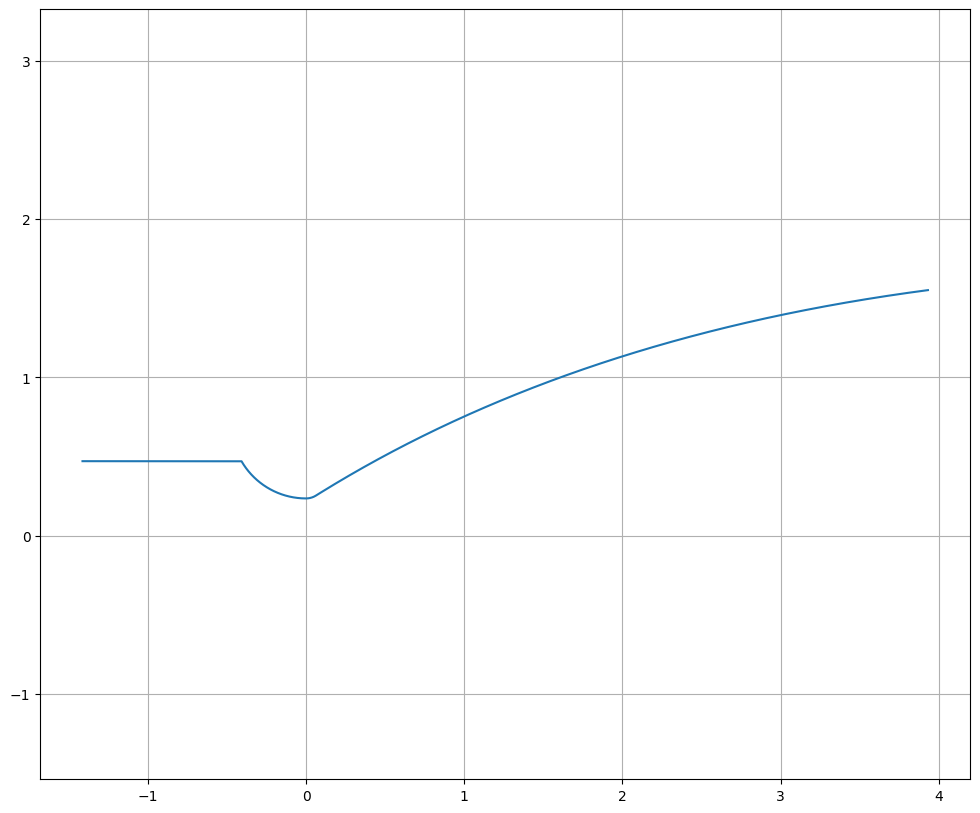

In [14]:
# Testing Block
nozzleData = pd.read_csv('Nozzle.csv')
plt.plot(nozzleData['X'], nozzleData['R'])
plt.gca().axis('equal')
plt.grid()

In [15]:
Pc = 30 * u.bar
Tc = 2500 * u.degreeK
commodity = 'Oxygen'



Cp = CP.PropsSI('CPMASS',
                'T', Tc.to('degreeK').magnitude,
                'P', Pc.to('Pa').magnitude,
                commodity)

gamma = Cp / CP.PropsSI('CVMASS',
                        'T', Tc.to('degreeK').magnitude,
                        'P', Pc.to('Pa').magnitude,
                        commodity)

rho1 = CP.PropsSI('D',
                 'T', Tc.to('degreeK').magnitude,
                 'P', Pc.to('Pa').magnitude,
                 commodity)

visc = CP.PropsSI('V',
                  'T', Tc.to('degreeK').magnitude,
                  'P', Pc.to('Pa').magnitude,
                  commodity)

MW = CP.PropsSI('M',
                'T', Tc.to('degreeK').magnitude,
                'P', Pc.to('Pa').magnitude,
                commodity)

nozzX = (np.array(nozzleData['X']) * u.feet).to('meter').magnitude
nozzD = (2 * np.array(nozzleData['R']) * u.inches).to('meter').magnitude
epsilon = 1e-05


M1 = 0.153
vel1 = M1 * np.sqrt(gamma * 8314 / MW / 1000 * Tc.magnitude)
print(vel1)

nozzle = GF.GeneralFlow(x_arr=nozzX,
                        D_arr = nozzD,
                        pointNum=100000,
                        Cp=Cp,
                        gamma=gamma)
nozzle.setICBeta(M1, vel1, Pc.to('Pa').magnitude, Tc.magnitude, rho1, visc, epsilon)
data = nozzle.runBeta()
data

139.09709928496616


In [ ]:
max(D_arr)**2 / (min(D_arr)**2)

62.000124000248015

In [ ]:
np.where(D_arr == min(D_arr))

(array([19999, 20000, 20001, ..., 79998, 79999, 80000]),)

In [ ]:
np.array(data['Mach'])[-1]

4.754392993435791

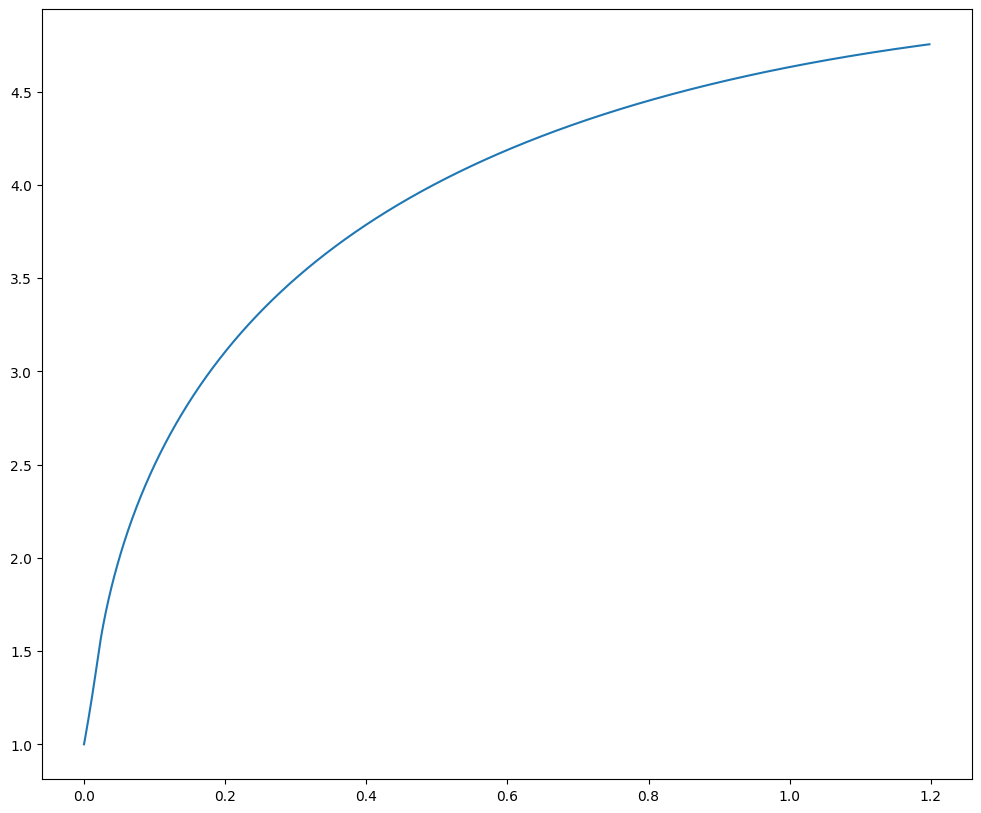

In [ ]:
plt.plot(data['x'], data['Mach'])

In [ ]:
testArr = np.array(data['x'])

max(D_arr)**2 / min(D_arr)**2

np.where(D_arr == max(D_arr))

(array([0]),)

In [ ]:
max(nozzD)**2 / min(nozzD)**2

43.45151240144341